In [1]:
# Created during May 25 HACKATHON by JD

# Calculates win percentage given on game score for both players.

In [19]:
from copy import deepcopy
import csv
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

log_folder = '../logs/'
log_file = log_folder + 'log_20200515_preendgames.csv'

todays_date = date.today().strftime("%Y%m%d")
pd.options.display.max_rows = 999

In [2]:
spread = {}
win_dict = {}

t0 = time.time()

# because moves are logged chronologically, we can overwrite the entry for each game ID
# for each move until we reach the final move, at which point we know the final state of the game.
with open(log_file,'r') as f:
    moveReader = csv.reader(f)
    next(moveReader)
    
    for i,row in enumerate(moveReader):
        if (i+1)%1000000==0:
            print('Processed {} rows in {} seconds'.format(i+1, time.time()-t0))
            
        if i<10:
            print(row)
                    
        # This flag indicates whether p1 won or not, with 0.5 as the value if the game was tied.
        if row[0]=='p1':
            spread[row[1]] = int(row[6])-int(row[11])
        else:
            spread[row[1]] = int(row[11])-int(row[6])

['p2', 'J3DH3KGZPuqMEDDcFXJauQ', '1', 'CEIIORT', '8H TORIC', '20', '20', '5', 'EI', '21.853', '86', '0']
['p1', 'J3DH3KGZPuqMEDDcFXJauQ', '2', 'CDEIIJW', '9G JEW', '36', '36', '3', 'CDII', '33.265', '81', '20']
['p2', 'J3DH3KGZPuqMEDDcFXJauQ', '3', 'EFIMOQT', '10F MOTE', '30', '50', '4', 'FIQ', '21.483', '78', '36']
['p1', 'J3DH3KGZPuqMEDDcFXJauQ', '4', 'ACDHIII', 'L7 A.IDIC', '22', '58', '5', 'HI', '22.994', '74', '50']
['p2', 'J3DH3KGZPuqMEDDcFXJauQ', '5', 'BEFGIOQ', '11C BEFOG', '37', '87', '5', 'IQ', '32.050', '69', '58']
['p2', 'wvTRHqNYEEjCHJiuGDw3WM', '1', 'DEIOSTW', '8D WITED', '26', '26', '5', 'OS', '32.236', '86', '0']
['p1', 'J3DH3KGZPuqMEDDcFXJauQ', '6', 'AHIOORV', '12D HAO', '32', '90', '3', 'IORV', '29.935', '64', '87']
['p1', 'wvTRHqNYEEjCHJiuGDw3WM', '2', 'DENRTWZ', 'E7 W.ZEN', '34', '34', '4', 'DRT', '34.836', '81', '26']
['p2', 'J3DH3KGZPuqMEDDcFXJauQ', '7', 'AINQRTV', 'J10 TRANQ', '45', '132', '5', 'IV', '40.426', '61', '90']
['p2', 'wvTRHqNYEEjCHJiuGDw3WM', '3', 'AB

In [3]:
for game_id in spread.keys():
    win_dict[game_id] = (np.sign(spread[game_id])+1)/2

Can define what spread beyond which you assume player has a 0 or 100% chance of winning - using 300 as first guess.

Also, spreads now range only from 0 to positive numbers, because trailing by 50 and winning is the same outcome and leading by 50 and losing (just swapping the players' perspectives)

In [4]:
max_spread = 300
counter_dict_by_spread_and_tiles_remaining = {x:{
    spread:0 for spread in range(max_spread,-max_spread-1,-1)} for x in range(0,94)}
win_counter_dict_by_spread_and_tiles_remaining = deepcopy(counter_dict_by_spread_and_tiles_remaining)

In [5]:
t0=time.time()
print('There are {} games'.format(len(win_dict)))

with open(log_file,'r') as f:
    moveReader = csv.reader(f)
    next(moveReader)
    
    for i,row in enumerate(moveReader):
        if (i+1)%1000000==0:
            print('Processed {} rows in {} seconds'.format(i+1, time.time()-t0))

        # truncate spread to the range -max_spread to max_spread
        end_of_turn_tiles_left = int(row[10])-int(row[7])
        end_of_turn_spread = min(max(int(row[6])-int(row[11]),-max_spread),max_spread)
        
        if end_of_turn_tiles_left > 0:
            counter_dict_by_spread_and_tiles_remaining[end_of_turn_tiles_left][end_of_turn_spread] += 1

            if row[0]=='p1':
                win_counter_dict_by_spread_and_tiles_remaining[
                    end_of_turn_tiles_left][end_of_turn_spread] += win_dict[row[1]]
            else:
                win_counter_dict_by_spread_and_tiles_remaining[
                    end_of_turn_tiles_left][end_of_turn_spread] += (1-win_dict[row[1]])
         
        # debug rows
#         if i<10:
#             print(row)
#             print(end_of_turn_spread)
#             print(end_of_turn_tiles_left)
#             print(counter_dict_by_spread_and_tiles_remaining[end_of_turn_tiles_left][end_of_turn_spread])
#             print(win_counter_dict_by_spread_and_tiles_remaining[end_of_turn_tiles_left][end_of_turn_spread])

There are 817267 games
Processed 1000000 rows in 3.838258981704712 seconds
Processed 2000000 rows in 7.635042905807495 seconds
Processed 3000000 rows in 11.481977939605713 seconds
Processed 4000000 rows in 15.787138938903809 seconds
Processed 5000000 rows in 20.211908102035522 seconds
Processed 6000000 rows in 24.085010051727295 seconds
Processed 7000000 rows in 28.0264949798584 seconds
Processed 8000000 rows in 31.966805934906006 seconds
Processed 9000000 rows in 35.94197392463684 seconds
Processed 10000000 rows in 39.805823802948 seconds
Processed 11000000 rows in 44.02776789665222 seconds
Processed 12000000 rows in 48.05650186538696 seconds
Processed 13000000 rows in 52.168529987335205 seconds
Processed 14000000 rows in 56.271294832229614 seconds
Processed 15000000 rows in 60.545756101608276 seconds
Processed 16000000 rows in 64.99189901351929 seconds
Processed 17000000 rows in 69.20510697364807 seconds
Processed 18000000 rows in 73.26069402694702 seconds


In [6]:
count_df = pd.DataFrame(counter_dict_by_spread_and_tiles_remaining)
win_df = pd.DataFrame(win_counter_dict_by_spread_and_tiles_remaining)
win_pct_df = win_df/count_df

Text(0.5, 1, 'Win % by tiles remaining and spread')

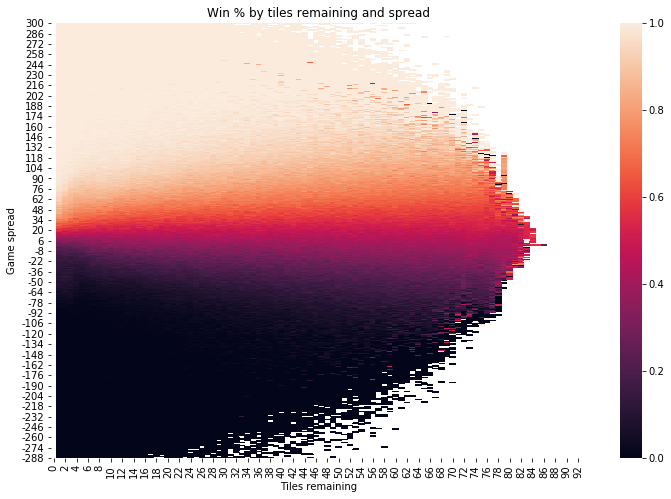

In [7]:
fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(win_pct_df, ax=ax)
ax.set_xlabel('Tiles remaining')
ax.set_ylabel('Game spread')
ax.set_title('Win % by tiles remaining and spread')

In [8]:
plt.savefig('win_pct.jpg')

<Figure size 432x288 with 0 Axes>

In [17]:
count_df.iloc[300:350,79:]

,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93
0,3672,5150,13104,18074,11970,3148,1550,4,0,0,0,0,0,0,0
-1,2969,1927,772,37,5,0,0,0,0,0,0,0,0,0,0
-2,3113,1701,434,26,2,0,0,0,0,0,0,0,0,0,0
-3,2736,1927,465,231,1,0,0,0,0,0,0,0,0,0,0
-4,2732,1524,539,36,2,0,0,0,0,0,0,0,0,0,0
-5,2453,1545,622,115,2,0,0,0,0,0,0,0,0,0,0
-6,2350,1571,468,79,2,0,0,0,0,0,0,0,0,0,0
-7,1951,1496,731,373,2,0,0,0,0,0,0,0,0,0,0
-8,1871,1124,464,31,13,0,0,0,0,0,0,0,0,0,0
-9,1544,1229,552,156,0,0,0,0,0,0,0,0,0,0,0


The 50% win line is likely a little bit above 0 spread, because when you end a turn with 0 spread, your opponent on average gets an extra half-turn more than you for the rest of the game. Let's fine that line.

In [20]:
win_pct_df.iloc[250:350,79:]

,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93
50,0.647059,0.619692,0.614761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,0.612245,0.478261,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,0.571429,0.628255,0.609531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,0.754717,0.578947,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,0.690909,0.615925,0.606714,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,0.500000,0.554545,0.562500,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,0.657143,0.592391,0.604121,0.583893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,0.462121,0.628571,0.615385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,0.606061,0.586187,0.584255,0.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,0.573171,0.675000,0.400000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Opening turn scores

In [ ]:
pd.options.display.max_rows = 999

## Apply smoothing
We want the win percentage to increase monotonically with spread, even though we have a limited sample size and this may not always be true. Therefore, we want to be able to average win percentages over neighboring scenarios (similar spread difference and similar # of tiles remaining).

In [53]:
counter_dict_by_opening_turn_score = {x:0 for x in range(0,131)}
win_counter_dict_by_opening_turn_score = {x:0 for x in range(0,131)}
rows = []

In [54]:
t0=time.time()
print('There are {} games'.format(len(win_dict)))

with open(log_file,'r') as f:
    moveReader = csv.reader(f)
    next(moveReader)
    
    for i,row in enumerate(moveReader):
        if (i+1)%1000000==0:
            print('Processed {} rows in {} seconds'.format(i+1, time.time()-t0))

        if row[2]=='1':
            counter_dict_by_opening_turn_score[int(row[5])] += 1
            
            # check which player went first
            if row[0]=='p1':
                win_counter_dict_by_opening_turn_score[int(row[5])] += win_dict[row[1]]
                rows.append([int(row[5]), win_dict[row[1]]])
            else:
                win_counter_dict_by_opening_turn_score[int(row[5])] += 1-win_dict[row[1]]
                rows.append([int(row[5]), 1-win_dict[row[1]]])

        
#         # debug rows
#         if i<10:
#             print(row)

There are 817267 games
Processed 1000000 rows in 1.7256970405578613 seconds
Processed 2000000 rows in 3.5004560947418213 seconds
Processed 3000000 rows in 5.197288990020752 seconds
Processed 4000000 rows in 7.002925872802734 seconds
Processed 5000000 rows in 8.714246034622192 seconds
Processed 6000000 rows in 10.444952964782715 seconds
Processed 7000000 rows in 12.125752925872803 seconds
Processed 8000000 rows in 13.777290105819702 seconds
Processed 9000000 rows in 15.482404947280884 seconds
Processed 10000000 rows in 17.13701105117798 seconds
Processed 11000000 rows in 18.79169011116028 seconds
Processed 12000000 rows in 20.506932973861694 seconds
Processed 13000000 rows in 22.161776065826416 seconds
Processed 14000000 rows in 23.818233013153076 seconds
Processed 15000000 rows in 25.57382607460022 seconds
Processed 16000000 rows in 27.434226989746094 seconds
Processed 17000000 rows in 29.10695195198059 seconds
Processed 18000000 rows in 30.76910901069641 seconds


In [57]:
tst_df=pd.DataFrame(rows).rename(columns={0:'opening turn score',1:'win'})

In [37]:
opening_turn_count = pd.Series(counter_dict_by_opening_turn_score)
opening_turn_win_count = pd.Series(win_counter_dict_by_opening_turn_score)
opening_turn_win_pct = opening_turn_win_count/opening_turn_count

In [47]:
tst = opening_turn_win_pct.dropna()

In [75]:
opening_turn_win_pct

0      0.499140
1           NaN
2           NaN
3           NaN
4      0.519046
5           NaN
6      0.508570
7           NaN
8      0.505871
9           NaN
10     0.512963
11          NaN
12     0.501936
13          NaN
14     0.506856
15          NaN
16     0.506898
17          NaN
18     0.509321
19          NaN
20     0.512011
21          NaN
22     0.514759
23          NaN
24     0.514265
25          NaN
26     0.516900
27          NaN
28     0.520995
29          NaN
30     0.529545
31          NaN
32     0.523308
33          NaN
34     0.529238
35          NaN
36     0.538586
37          NaN
38     0.536739
39          NaN
40     0.537345
41          NaN
42     0.552219
43          NaN
44     0.549655
45          NaN
46     0.555181
47          NaN
48     0.554317
49          NaN
50     0.556818
51          NaN
52     0.566059
53          NaN
54     0.574432
55          NaN
56     0.567811
57          NaN
58     0.590347
59          NaN
60     0.594044
61          NaN
62     0

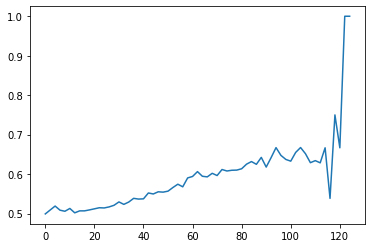

In [70]:
fig,ax=plt.subplots()
plt.plot(tst)
plt.savefig('plot1.png')

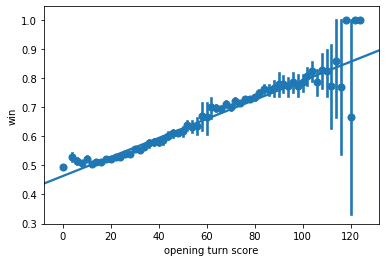

In [71]:
fig,ax=plt.subplots()
sns.regplot(x='opening turn score',y='win',data=tst_df,x_estimator=np.mean,ax=ax)
plt.savefig('regression_plot.png')

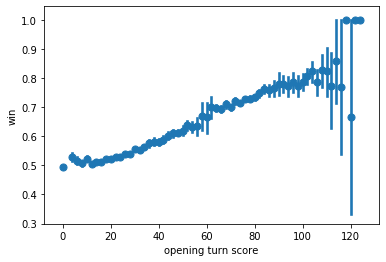

In [76]:
fig,ax=plt.subplots()
sns.regplot(x='opening turn score',y='win',data=tst_df,x_estimator=np.mean,ax=ax,fit_reg=False)
plt.savefig('regression_plot_no_fitline.png')